In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import RandomOverSampler 

from functions.Pre_processing_Casos_Graves import *
from functions.Pre_processing_models import *

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection._split import StratifiedKFold

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

#### Lendo o dataset:

In [2]:
df = pd.read_csv('..\Data\Casos Graves\df_casos_graves')

#### Utilizando a class de pré-processamento para preparar o dataset:

In [3]:
list_features = ["SYMPTOM_COUGH",'SYMPTOM_COLD','SYMPTOM_AIR_INSUFFICIENCY','SYMPTOM_FEVER','SYMPTOM_LOW_OXYGEN_SATURATION','SYMPTOM_BREATHING_CONDITION','SYMPTOM_TORACIC_APERTURE','SYMPTOM_THROAT_CONDITION',
                'SYMPTOM_HEADACHE','SYMPTOM_BODY_PAIN','SYMPTOM_DIARRHEA','SYMPTOM_RUNNY_NOSE','SYMPTOM_NOSE_CONGESTION','SYMPTOM_WEAKNESS','SYMPTOM_ANOSMIA_OR_HYPOSMIA','SYMPTOM_NAUSEA','SYMPTOM_LACK_OF_APPETITE',
                'SYMPTOM_ABDOMINAL_PAIN','SYMPTOM_CONSCIOUSNESS_DEGRADATION','DISEASE_HEART_OR_VASCULAR','DISEASE_DIABETES','DISEASE_HYPERTENSION','DISEASE_RESPIRATORY','DISEASE_OBESITY','DISEASE_KIDNEY','DISEASE_IMMUNOSUPPRESSION',
                'DISEASE_TABAGIST','DISEASE_ETILISM','DISEASE_LIVER','DISEASE_NEUROLOGIC','death', 'idade', 'sexo_Feminino','sexo_Masculino', 'data_notificacao']
features = np.array(list_features)

In [4]:
Pre_processing_models_df = Pre_processing_models(df)
Pre_processing_models_df.run_graves()

df = Pre_processing_models_df.df
df = df[list_features]
df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])
df = df.sort_values(by='data_notificacao', ascending=True)
df = df.reset_index()
df = df.drop("index", axis=1)
df

C:\Users\maril\AppData\Local\Temp\ipykernel_23200\3432879523.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.356522,0,1,2020-02-26
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.278261,0,1,2020-02-26
2,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.217391,1,0,2020-02-27
3,1,0,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0.278261,0,1,2020-02-27
4,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0.260870,1,0,2020-02-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36430,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,1,0,2022-06-12
36431,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.556522,0,1,2022-06-12
36432,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.573913,1,0,2022-06-12
36433,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0,1,2022-06-13


### Criação de uma função para configuração do modelo:

In [15]:
from sklearn.ensemble import RandomForestClassifier

def instantiate_RandomForest_model (X_train, y_train):
    param_grid = {
        'max_depth':[3,5,10,None],
        'n_estimators':[10,100,200],
        'max_features':[1,3,5,7],
        'min_samples_leaf':[1,2,3],
        'min_samples_split':[2,3,4]
           }

    # Init classifier
    rf_cl = RandomForestClassifier()

    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 1)

    # Init Grid Search
    grid_cv = GridSearchCV(rf_cl, param_grid, n_jobs = -1, cv=5, scoring = "roc_auc", error_score='raise')

    # Fit 
    _ = grid_cv.fit(X_train, y_train)

    mean_test_score = grid_cv.cv_results_['mean_test_score'].mean()
    std_test_score = grid_cv.cv_results_['std_test_score'].mean()
    best_score = grid_cv.best_score_
    best_params = grid_cv.best_params_

    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score']}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score']}")
    #print('')

    print('#'*40)
    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score'].mean()}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score'].mean()}")
    print('')
    print(f'best_score: {grid_cv.best_score_}')
    print(f'best_params_: {grid_cv.best_params_}')
    print('#'*40)
    print('')

    return mean_test_score, std_test_score, best_score, best_params

### Criação de uma função para aplicação do modelo:

In [11]:
def apply_model_randomforest(df):
    list_random_states = [0, 42, 50, 54]

    mean_test_scores = []
    std_test_scores = []
    best_scores = []
    best_params = []

    #treino!
    data_inicio = df['data_notificacao'][0]
    data_fim = df['data_notificacao'][0]+pd.Timedelta(days=45)
    
    treino = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] <= data_fim )]
    X_train = treino.drop(labels=['death', 'data_notificacao'], axis=1)
    y_train = treino['death']

    #teste!
    teste = df[(df['data_notificacao'] > data_fim)]
    X_test = teste.drop(labels=['death', 'data_notificacao'], axis=1)
    y_test = teste['death']

    oversample = RandomOverSampler(sampling_strategy='minority')
    X_over, y_over = oversample.fit_resample(X_train, y_train)


    for random_state in list_random_states:

        mean_test_score, std_test_score, best_score, best_param = instantiate_RandomForest_model(X_over, y_over)

        mean_test_scores.append(mean_test_score)
        std_test_scores.append(std_test_score)
        best_scores.append(best_score)
        best_params.append(best_param)

    return (X_over, y_over, X_test, y_test, mean_test_scores, std_test_scores, best_scores, best_params)

### Criação de uma função para imprimir as métricas do classificador final de cada modelo:

In [7]:
from sklearn.ensemble import RandomForestClassifier

def create_final_cl(X_over, y_over, X_test, y_test, max_depth, n_estimators, max_features, min_samples_leaf, min_samples_split):

    # parametrizando o modelo final
    final_cl = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators, max_features = max_features, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
    #treinando o modelo final
    final_cl.fit(X_over, y_over)
    preds = final_cl.predict(X_test)
    accuracy_score(y_test, preds)

    print('accuracy_score:', accuracy_score(y_test, preds))
    print('#'*40)

    print('"""Métricas f1_score:"""')
    print('f1: ', f1_score(y_test, preds))
    print('Macro: ', f1_score(y_test, preds, average='macro'))
    print('Micro: ', f1_score(y_test, preds, average='micro'))
    print('weighted: ', f1_score(y_test, preds, average='weighted'))
    print('#'*40)
    print('"""Métricas precision_score:"""')
    print('Precision: ', precision_score(y_test, preds))
    print('Macro: ', precision_score(y_test, preds, average='macro'))
    print('Micro: ', precision_score(y_test, preds, average='micro'))
    print('weighted: ', precision_score(y_test, preds, average='weighted'))

    return preds, final_cl

### Criação de funções para gerar a matriz de confusão e classification report:

In [8]:
def plot_conf_matrix (X_test, y_test, preds, final_cl):

    confusion_matrix(y_test, preds)
    matrix = plot_confusion_matrix(final_cl, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()
    print(classification_report(y_test, preds))


def plot_roc_curve(y_test, preds):
    
    print('roc_auc_score: ', roc_auc_score(y_test, preds, multi_class='ovr'))

    fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
    auc = metrics.roc_auc_score(y_test, preds)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

def plot_feature_importance(final_cl, list_features):
    # plot feature importance
    imp_features = final_cl.feature_importances_
    df_imp_features = pd.DataFrame({"features":list_features}).join(pd.DataFrame({"weights":imp_features}))
    df_imp_features = df_imp_features.sort_values(by=['weights'], ascending=False)
    df_imp_features.plot(x="features", y="weights", kind="bar", figsize=(8, 4))
    plt.show()

### Teste com o Período 1 (26/02/2020 até 25/05/2020):

In [9]:
#Periodo 1
data_inicio = df['data_notificacao'][0]
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=90)

df_1 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim)]
df_1

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.356522,0,1,2020-02-26
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.278261,0,1,2020-02-26
2,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.217391,1,0,2020-02-27
3,1,0,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0.278261,0,1,2020-02-27
4,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0.260870,1,0,2020-02-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10818,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.400000,0,1,2020-05-25
10819,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.626087,0,1,2020-05-25
10820,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.704348,1,0,2020-05-25
10821,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0.782609,0,1,2020-05-25


In [16]:
X_train_oversampled_1, y_train_oversampled_1, X_test_1, y_test_1, mean_test_scores_1, std_test_scores_1, best_scores_1, best_params_1 = apply_model_randomforest(df_1)

########################################

best_score: 0.9686731986894517
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9674633802250823
best_params_: {'max_depth': None, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.967934631843811
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################

########################################

best_score: 0.9685351490109093
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################



In [17]:
preds_1, final_cl_1 = create_final_cl(X_train_oversampled_1, y_train_oversampled_1, X_test_1, y_test_1, None, 7, 1, 2, 200)

accuracy_score: 0.7696055684454757
########################################
"""Métricas f1_score:"""
f1:  0.61837048424289
Macro:  0.7266827495990122
Micro:  0.7696055684454757
weighted:  0.785211581620917
########################################
"""Métricas precision_score:"""
Precision:  0.4992243251628917
Macro:  0.7151485716976216
Micro:  0.7696055684454757
weighted:  0.8318278223192886


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


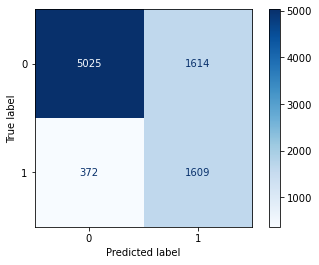

              precision    recall  f1-score   support

           0       0.93      0.76      0.83      6639
           1       0.50      0.81      0.62      1981

    accuracy                           0.77      8620
   macro avg       0.72      0.78      0.73      8620
weighted avg       0.83      0.77      0.79      8620

roc_auc_score:  0.7845535752778372


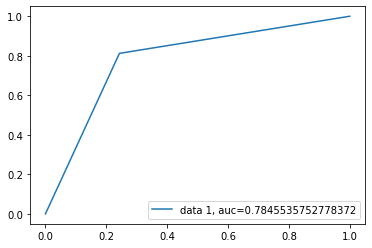

In [18]:
plot_conf_matrix (X_test_1, y_test_1, preds_1, final_cl_1)

plot_roc_curve(y_test_1, preds_1)

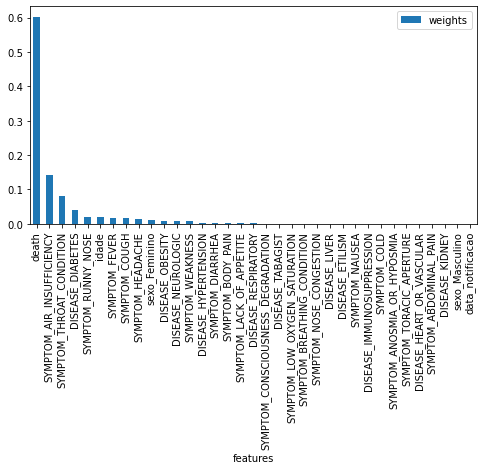

In [20]:
plot_feature_importance(final_cl_1, list_features)

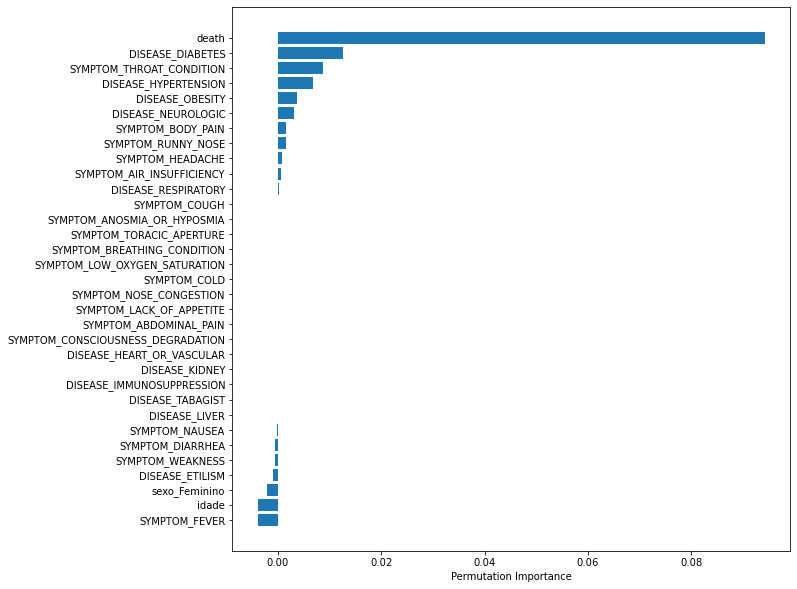

In [15]:
plot_permutation_importance(final_cl_1, X_test_1, y_test_1)

### Definição dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_1)
plt.show()

### Teste com o Período 2 (27/03/2020 até 24/06/2020):

In [ ]:
#Periodo 2
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=30)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=120)

df_2 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_2 = df_2.reset_index()
df_2 = df_2.drop("index", axis=1)
df_2

In [ ]:
X_train_oversampled_2, y_train_oversampled_2, X_test_2, y_test_2, mean_test_scores_2, std_test_scores_2, best_scores_2, best_params_2 = apply_model_xgboost(df_2)

In [ ]:
preds_2, final_cl_2 = create_final_cl(X_train_oversampled_2, y_train_oversampled_2, X_test_2, y_test_2, 0.9, 0.25, 7, 3)

In [ ]:
plot_conf_matrix (X_test_2, y_test_2, preds_2, final_cl_2)

plot_roc_curve(y_test_2, preds_2)

### Definição dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_2)
plt.show()

### Teste com o Período 3 (26/04/2020 até 24/07/2020):

In [ ]:
#Periodo 3
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=60)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=150)

df_3 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_3 = df_3.reset_index()
df_3 = df_3.drop("index", axis=1)
df_3

In [ ]:
X_train_oversampled_3, y_train_oversampled_3, X_test_3, y_test_3, mean_test_scores_3, std_test_scores_3, best_scores_3, best_params_3 = apply_model_xgboost(df_3)

In [ ]:
preds_3, final_cl_3 = create_final_cl(X_train_oversampled_3, y_train_oversampled_3, X_test_3, y_test_3, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_3, y_test_3, preds_3, final_cl_3)

plot_roc_curve(y_test_3, preds_3)

### Definição dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_3)
plt.show()

### Teste com o Período 4 (26/05/2020 até 23/08/2020):

In [ ]:
#Periodo 4
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=90)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=180)

df_4 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_4 = df_4.reset_index()
df_4 = df_4.drop("index", axis=1)
df_4

In [ ]:
X_train_oversampled_4, y_train_oversampled_4, X_test_4, y_test_4, mean_test_scores_4, std_test_scores_4, best_scores_4, best_params_4 = apply_model_xgboost(df_4)

In [ ]:
preds_4, final_cl_4 = create_final_cl(X_train_oversampled_4, y_train_oversampled_4, X_test_4, y_test_4, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_4, y_test_4, preds_4, final_cl_4)

plot_roc_curve(y_test_4, preds_4)

### Definição dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_4)
plt.show()

### Teste com o Período 5 (25/06/2020 até 22/09/2020):

In [ ]:
#Periodo 5
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=120)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=210)

df_5 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_5 = df_5.reset_index()
df_5 = df_5.drop("index", axis=1)
df_5

In [ ]:
X_train_oversampled_5, y_train_oversampled_5, X_test_5, y_test_5, mean_test_scores_5, std_test_scores_5, best_scores_5, best_params_5 = apply_model_xgboost(df_5)

In [ ]:
preds_5, final_cl_5 = create_final_cl(X_train_oversampled_5, y_train_oversampled_5, X_test_5, y_test_5, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_5, y_test_5, preds_5, final_cl_5)

plot_roc_curve(y_test_5, preds_5)

### Definição dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_5)
plt.show()

### Teste com o Período 6 (25/07/2020 até 22/10/2020):

In [ ]:
#Periodo 6
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=150)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=240)

df_6 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_6 = df_6.reset_index()
df_6 = df_6.drop("index", axis=1)
df_6

In [ ]:
X_train_oversampled_6, y_train_oversampled_6, X_test_6, y_test_6, mean_test_scores_6, std_test_scores_6, best_scores_6, best_params_6 = apply_model_xgboost(df_6)

In [ ]:
preds_6, final_cl_6 = create_final_cl(X_train_oversampled_6, y_train_oversampled_6, X_test_6, y_test_6, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_6, y_test_6, preds_6, final_cl_6)

plot_roc_curve(y_test_6, preds_6)

### Definição dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_6)
plt.show()

### Teste com o Período 7 (24/08/2020 até 21/11/2020):

In [ ]:
#Periodo 7
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=180)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=270)

df_7 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_7 = df_7.reset_index()
df_7 = df_7.drop("index", axis=1)
df_7

In [ ]:
X_train_oversampled_7, y_train_oversampled_7, X_test_7, y_test_7, mean_test_scores_7, std_test_scores_7, best_scores_7, best_params_7 = apply_model_xgboost(df_7)

In [ ]:
preds_7, final_cl_7 = create_final_cl(X_train_oversampled_7, y_train_oversampled_7, X_test_7, y_test_7, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_7, y_test_7, preds_7, final_cl_7)

plot_roc_curve(y_test_7, preds_7)

### Definição dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_7)
plt.show()


### Teste com o Período 8 (23/09/2020 até 21/12/2020):

In [ ]:
#Periodo 8
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=210)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=300)

df_8 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_8 = df_8.reset_index()
df_8 = df_8.drop("index", axis=1)
df_8

In [ ]:
X_train_oversampled_8, y_train_oversampled_8, X_test_8, y_test_8, mean_test_scores_8, std_test_scores_8, best_scores_8, best_params_8 = apply_model_xgboost(df_8)

In [ ]:
preds_8, final_cl_8 = create_final_cl(X_train_oversampled_8, y_train_oversampled_8, X_test_8, y_test_8, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_8, y_test_8, preds_8, final_cl_8)

plot_roc_curve(y_test_8, preds_8)

### Determinação dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_8)
plt.show()

### Teste com o Período 9 (23/10/2020 até 20/01/2021):

In [ ]:
#Periodo 9
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=240)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=330)

df_9 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_9 = df_9.reset_index()
df_9 = df_9.drop("index", axis=1)
df_9

In [ ]:
X_train_oversampled_9, y_train_oversampled_9, X_test_9, y_test_9, mean_test_scores_9, std_test_scores_9, best_scores_9, best_params_9 = apply_model_xgboost(df_9)

In [ ]:
preds_9, final_cl_9 = create_final_cl(X_train_oversampled_9, y_train_oversampled_9, X_test_9, y_test_9, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_9, y_test_9, preds_9, final_cl_9)

plot_roc_curve(y_test_9, preds_9)

### Definição dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_9)
plt.show()

### Teste com o Período 10 (22/11/2020 até 19/02/2021):

In [ ]:
#Periodo 10
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=270)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=360)

df_10 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_10 = df_10.reset_index()
df_10 = df_10.drop("index", axis=1)
df_10

In [ ]:
X_train_oversampled_10, y_train_oversampled_10, X_test_10, y_test_10, mean_test_scores_10, std_test_scores_10, best_scores_10, best_params_10 = apply_model_xgboost(df_10)

In [ ]:
preds_10, final_cl_10 = create_final_cl(X_train_oversampled_10, y_train_oversampled_10, X_test_10, y_test_10, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_10, y_test_10, preds_10, final_cl_10)

plot_roc_curve(y_test_10, preds_10)

### Definição dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_10)
plt.show()

### Teste com o Período 11 (22/12/2020 até 21/03/2021):

In [ ]:
#Periodo 11
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=300)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=390)

df_11 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_11 = df_11.reset_index()
df_11 = df_11.drop("index", axis=1)
df_11

In [ ]:
X_train_oversampled_11, y_train_oversampled_11, X_test_11, y_test_11, mean_test_scores_11, std_test_scores_11, best_scores_11, best_params_11 = apply_model_xgboost(df_11)

In [ ]:
preds_11, final_cl_11 = create_final_cl(X_train_oversampled_11, y_train_oversampled_11, X_test_11, y_test_11, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_11, y_test_11, preds_11, final_cl_11)

plot_roc_curve(y_test_11, preds_11)

### Definição dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_11)
plt.show()

### Teste com o Período 12 (21/01/2021 até 20/04/2021):

In [ ]:
#Periodo 12
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=330)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=420)

df_12 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_12 = df_12.reset_index()
df_12 = df_12.drop("index", axis=1)
df_12

In [ ]:
X_train_oversampled_12, y_train_oversampled_12, X_test_12, y_test_12, mean_test_scores_12, std_test_scores_12, best_scores_12, best_params_12 = apply_model_xgboost(df_12)

In [ ]:
preds_12, final_cl_12 = create_final_cl(X_train_oversampled_12, y_train_oversampled_12, X_test_12, y_test_12, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_12, y_test_12, preds_12, final_cl_12)

plot_roc_curve(y_test_12, preds_12)

### Definição dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_12)
plt.show()

### Teste com o Período 13 (20/02/2021 até 20/05/2021):

In [ ]:
#Periodo 13
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=360)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=450)

df_13 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_13 = df_13.reset_index()
df_13 = df_13.drop("index", axis=1)
df_13

In [ ]:
X_train_oversampled_13, y_train_oversampled_13, X_test_13, y_test_13, mean_test_scores_13, std_test_scores_13, best_scores_13, best_params_13 = apply_model_xgboost(df_13)

In [ ]:
preds_13, final_cl_13 = create_final_cl(X_train_oversampled_13, y_train_oversampled_13, X_test_13, y_test_13, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_13, y_test_13, preds_13, final_cl_13)

plot_roc_curve(y_test_13, preds_13)

### Definição dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_13)
plt.show()

### Teste com o Período 14 (22/03/2021 até 19/06/2021):

In [ ]:
#Periodo 14
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=390)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=480)

df_14 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_14 = df_14.reset_index()
df_14 = df_14.drop("index", axis=1)
df_14

In [ ]:
X_train_oversampled_14, y_train_oversampled_14, X_test_14, y_test_14, mean_test_scores_14, std_test_scores_14, best_scores_14, best_params_14 = apply_model_xgboost(df_14)

In [ ]:
preds_14, final_cl_14 = create_final_cl(X_train_oversampled_14, y_train_oversampled_14, X_test_14, y_test_14, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_14, y_test_14, preds_14, final_cl_14)

plot_roc_curve(y_test_14, preds_14)

### Definição dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_14)
plt.show()

### Teste com o Período 15 (21/04/2021 até 19/07/2021):

In [ ]:
#Periodo 15
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=420)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=510)

df_15 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_15 = df_15.reset_index()
df_15 = df_15.drop("index", axis=1)
df_15

In [ ]:
X_train_oversampled_15, y_train_oversampled_15, X_test_15, y_test_15, mean_test_scores_15, std_test_scores_15, best_scores_15, best_params_15 = apply_model_xgboost(df_15)

In [ ]:
preds_15, final_cl_15 = create_final_cl(X_train_oversampled_15, y_train_oversampled_15, X_test_15, y_test_15, 0.9, 0.25, 7, 3)

In [ ]:
plot_conf_matrix (X_test_15, y_test_15, preds_15, final_cl_15)

plot_roc_curve(y_test_15, preds_15)

### Determinação dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_15)
plt.show()

### Teste com o Período 16 (21/05/2021 até 18/08/2021):

In [ ]:
#Periodo 16
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=450)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=540)

df_16 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_16 = df_16.reset_index()
df_16 = df_16.drop("index", axis=1)
df_16

In [ ]:
X_train_oversampled_16, y_train_oversampled_16, X_test_16, y_test_16, mean_test_scores_16, std_test_scores_16, best_scores_16, best_params_16 = apply_model_xgboost(df_16)

In [ ]:
preds_16, final_cl_16 = create_final_cl(X_train_oversampled_16, y_train_oversampled_16, X_test_16, y_test_16, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_16, y_test_16, preds_16, final_cl_16)

plot_roc_curve(y_test_16, preds_16)

### Determinação dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_16)
plt.show()

### Teste com o Período 17 (20/06/2021 até 17/09/2021):

In [ ]:
#Periodo 17
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=480)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=570)

df_17 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_17 = df_17.reset_index()
df_17 = df_17.drop("index", axis=1)
df_17

In [ ]:
X_train_oversampled_17, y_train_oversampled_17, X_test_17, y_test_17, mean_test_scores_17, std_test_scores_17, best_scores_17, best_params_17 = apply_model_xgboost(df_17)

In [ ]:
preds_17, final_cl_17 = create_final_cl(X_train_oversampled_17, y_train_oversampled_17, X_test_17, y_test_17, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_17, y_test_17, preds_17, final_cl_17)

plot_roc_curve(y_test_17, preds_17)

### Determinação dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_17)
plt.show()

### Teste com o Período 18 (20/07/2021 até 17/10/2021):

In [ ]:
#Periodo 18
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=510)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=600)

df_18 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_18 = df_18.reset_index()
df_18 = df_18.drop("index", axis=1)
df_18

In [ ]:
X_train_oversampled_18, y_train_oversampled_18, X_test_18, y_test_18, mean_test_scores_18, std_test_scores_18, best_scores_18, best_params_18 = apply_model_xgboost(df_18)

In [ ]:
preds_18, final_cl_18 = create_final_cl(X_train_oversampled_18, y_train_oversampled_18, X_test_18, y_test_18, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_18, y_test_18, preds_18, final_cl_18)

plot_roc_curve(y_test_18, preds_18)

### Determinação dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_18)
plt.show()

### Teste com o Período 19 (19/08/2021 até 16/11/2021):

In [ ]:
#Periodo 19
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=540)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=630)

df_19 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_19 = df_19.reset_index()
df_19 = df_19.drop("index", axis=1)
df_19

In [ ]:
X_train_oversampled_19, y_train_oversampled_19, X_test_19, y_test_19, mean_test_scores_19, std_test_scores_19, best_scores_19, best_params_19 = apply_model_xgboost(df_19)

In [ ]:
preds_19, final_cl_19 = create_final_cl(X_train_oversampled_19, y_train_oversampled_19, X_test_19, y_test_19, 0.9, 0.25, 7, 3)

In [ ]:
plot_conf_matrix (X_test_19, y_test_19, preds_19, final_cl_19)

plot_roc_curve(y_test_19, preds_19)

### Determinação dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_19)
plt.show()

### Teste com o Período 20 (18/09/2021 até 16/12/2021):

In [ ]:
#Periodo 20
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=570)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=660)

df_20 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_20 = df_20.reset_index()
df_20 = df_20.drop("index", axis=1)
df_20

In [ ]:
X_train_oversampled_20, y_train_oversampled_20, X_test_20, y_test_20, mean_test_scores_20, std_test_scores_20, best_scores_20, best_params_20 = apply_model_xgboost(df_20)

In [ ]:
preds_20, final_cl_20 = create_final_cl(X_train_oversampled_20, y_train_oversampled_20, X_test_20, y_test_20, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_20, y_test_20, preds_20, final_cl_20)

plot_roc_curve(y_test_20, preds_20)

### Determinação dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_20)
plt.show()

### Teste com o Período 21 (18/10/2021 até 15/01/2022):

In [ ]:
#Periodo 21
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=600)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=690)

df_21 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_21 = df_21.reset_index()
df_21 = df_21.drop("index", axis=1)
df_21

In [ ]:
X_train_oversampled_21, y_train_oversampled_21, X_test_21, y_test_21, mean_test_scores_21, std_test_scores_21, best_scores_21, best_params_21 = apply_model_xgboost(df_21)

In [ ]:
preds_21, final_cl_21 = create_final_cl(X_train_oversampled_21, y_train_oversampled_21, X_test_21, y_test_21, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_21, y_test_21, preds_21, final_cl_21)

plot_roc_curve(y_test_21, preds_21)

### Determinação dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_21)
plt.show()

### Teste com o Período 22 (17/11/2021 até 14/02/2022):

In [ ]:
#Periodo 22
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=630)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=720)

df_22 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_22 = df_22.reset_index()
df_22 = df_22.drop("index", axis=1)
df_22

In [ ]:
X_train_oversampled_22, y_train_oversampled_22, X_test_22, y_test_22, mean_test_scores_22, std_test_scores_22, best_scores_22, best_params_22 = apply_model_xgboost(df_22)

In [ ]:
preds_22, final_cl_22 = create_final_cl(X_train_oversampled_22, y_train_oversampled_22, X_test_22, y_test_22, 0.9, 1, 7, 5)

In [ ]:
plot_conf_matrix (X_test_22, y_test_22, preds_22, final_cl_22)

plot_roc_curve(y_test_22, preds_22)

### Determinação dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_22)
plt.show()

### Teste com o Período 23 (17/12/2021 até 16/03/2022):

In [ ]:
#Periodo 23
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=660)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=750)

df_23 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_23 = df_23.reset_index()
df_23 = df_23.drop("index", axis=1)
df_23

In [ ]:
X_train_oversampled_23, y_train_oversampled_23, X_test_23, y_test_23, mean_test_scores_23, std_test_scores_23, best_scores_23, best_params_23 = apply_model_xgboost(df_23)

In [ ]:
preds_23, final_cl_23 = create_final_cl(X_train_oversampled_23, y_train_oversampled_23, X_test_23, y_test_23, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_23, y_test_23, preds_23, final_cl_23)

plot_roc_curve(y_test_23, preds_23)

### Determinação dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_23)
plt.show()

### Teste com o Período 24 (16/01/2022 até 15/04/2022):

In [ ]:
#Periodo 24
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=690)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=780)

df_24 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_24 = df_24.reset_index()
df_24 = df_24.drop("index", axis=1)
df_24

In [ ]:
X_train_oversampled_24, y_train_oversampled_24, X_test_24, y_test_24, mean_test_scores_24, std_test_scores_24, best_scores_24, best_params_24 = apply_model_xgboost(df_24)

In [ ]:
preds_24, final_cl_24 = create_final_cl(X_train_oversampled_24, y_train_oversampled_24, X_test_24, y_test_24, 0.9, 0.25, 7, 3)

In [ ]:
plot_conf_matrix (X_test_24, y_test_24, preds_24, final_cl_24)

plot_roc_curve(y_test_24, preds_24)

### Determinação dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_24)
plt.show()

### Teste com o Período 25 (15/02/2022 até 15/05/2021):

In [ ]:
#Periodo 25
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=720)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=810)

df_25 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_25 = df_25.reset_index()
df_25 = df_25.drop("index", axis=1)
df_25

In [ ]:
X_train_oversampled_25, y_train_oversampled_25, X_test_25, y_test_25, mean_test_scores_25, std_test_scores_25, best_scores_25, best_params_25 = apply_model_xgboost(df_25)

In [ ]:
preds_25, final_cl_25 = create_final_cl(X_train_oversampled_25, y_train_oversampled_25, X_test_25, y_test_25, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_25, y_test_25, preds_25, final_cl_25)

plot_roc_curve(y_test_25, preds_25)

### Determinação dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_25)
plt.show()

### Teste com o Período 26 (17/03/2022 até 13/06/2022):

In [12]:
#Periodo 26
data_inicio = df['data_notificacao'][0]+pd.Timedelta(days=750)
data_fim = df['data_notificacao'][0]+pd.Timedelta(days=840)

df_26 = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] < data_fim )]
df_26 = df_26.reset_index()
df_26 = df_26.drop("index", axis=1)
df_26

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0.582609,0,1,2022-03-17
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.513043,0,1,2022-03-17
2,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0.678261,1,0,2022-03-17
3,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.530435,1,0,2022-03-17
4,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0.426087,0,1,2022-03-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,1,0,2022-06-12
1391,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.556522,0,1,2022-06-12
1392,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.573913,1,0,2022-06-12
1393,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0,1,2022-06-13


In [13]:
X_train_oversampled_26, y_train_oversampled_26, X_test_26, y_test_26, mean_test_scores_26, std_test_scores_26, best_scores_26, best_params_26 = apply_model_randomforest(df_26)

c:\Users\maril\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\maril\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\maril\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\Users\maril\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\maril\anaconda3\lib\site-package

########################################

best_score: 0.8541155453536655
best_params_: {'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################



c:\Users\maril\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\maril\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\maril\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\Users\maril\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\maril\anaconda3\lib\site-package

########################################

best_score: 0.853581176617984
best_params_: {'max_depth': None, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
########################################



In [ ]:
preds_26, final_cl_26 = create_final_cl(X_train_oversampled_26, y_train_oversampled_26, X_test_26, y_test_26, 0.9, 0.25, 7, 5)

In [ ]:
plot_conf_matrix (X_test_26, y_test_26, preds_26, final_cl_26)

plot_roc_curve(y_test_26, preds_26)

### Determinação dos atributos mais importantes:

In [ ]:
# plot feature importance
plt.figure(figsize=(10,10))
plot_importance(final_cl_26)
plt.show()